# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
    
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)

In [3]:
# Define global functions here, if required

## 1. Implement ε-greedy and UCB MABs

In [4]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        if epsilon < 0:
            raise ValueError("`epsilon` must be non-negative")
        if Q0 < 0:
            raise ValueError("`initial Q-value` must be non-negative")
            
        self.epsilon = epsilon
        self.q0 = Q0
        self.rewards = [self.q0] * self.n_arms
        self.counts = [0] * self.n_arms
    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        if np.random.random() < self.epsilon:
            arm = np.random.randint(0, self.n_arms)
        else:
            # compute q values
            q_values = []
            for i in range(self.n_arms):
                if self.counts[i] > 0:
                    q_values.append(self.rewards[i] / self.counts[i])
                else:
                    q_values.append(self.q0)
            _max = max(q_values)
            
            # select all the arms with max q value
            if _max == self.q0:
                _maxi = [i for i in range(self.n_arms) if q_values[i] == _max]
            else:
                _maxi = [i for i in range(self.n_arms) if abs(q_values[i] - _max) < 0.00001]
            arm = np.random.choice(_maxi)
        return arm
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        if arm < 0 or arm >= self.n_arms:
            raise ValueError("invalid arm")
            
        # your code here
        self.counts[arm] += 1
        if self.rewards[arm] == self.q0:
            self.rewards[arm] = reward
        else:
            self.rewards[arm] += reward

In [5]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        if rho <= 0:
            raise ValueError("`rho` must be positive")
        if Q0 < 0:
            raise ValueError("`initial Q-value` must be non-negative")
            
        self.rho = rho
        self.q0 = Q0
        self.counts = [0] * self.n_arms
        self.rewards = [self.q0] * self.n_arms
        self.t = 1
    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        # compute q values
        q_values = []
        for i in range(self.n_arms):
            if self.counts[i] > 0:
                q_values.append(self.rewards[i]  / self.counts[i]
                               + np.sqrt(self.rho * np.log(self.t) / self.counts[i]))
            else:
                q_values.append(self.q0)
        _max = max(q_values)
        
        # select all the arms with max q value
        if _max == self.q0:
            _maxi = [i for i in range(self.n_arms) if q_values[i] == _max]
        else:
            _maxi = [i for i in range(self.n_arms) if abs(q_values[i] - _max) < 0.00001]
        arm = np.random.choice(_maxi)
        return arm
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
        if arm < 0 or arm >= self.n_arms:
            raise ValueError("invalid arm")
            
        self.t += 1
        self.counts[arm] += 1
        if self.rewards[arm] == self.q0:
            self.rewards[arm] = reward
        else:
            self.rewards[arm] += reward

## 2. Implement off-policy evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # your code here
    if not isinstance(arms,np.ndarray):
        raise ValueError("arms is not numpy array")
    if not isinstance(rewards,np.ndarray):
        raise ValueError("rewards is not numpy array")
    if not isinstance(contexts,np.ndarray):
        raise ValueError("contexts is not numpy array")
    if rewards.shape[0] != arms.shape[0] or contexts.shape[0] != arms.shape[0]:
        raise ValueError("data shape invalid")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("number of arms in contexts is wrong")
        
    _return = []
    history = []
    R = 0
    
    if n_rounds == None:
        while mab.play(contexts[i]) != arms[i] and i < len(arms):
            i += 1

            if i == len(arms):
                break

            arm = arms[i]
            reward = rewards[i]
            R += reward

            history.append((contexts[i], arm, reward))
            mab.update(arm, reward, contexts[i])
            _return.append(reward)
#             _return.append(R/(t+1))
            i += 1
    else:
        if not np.issubdtype(type(n_rounds), np.integer):
            raise TypeError("`n_rounds` must be an integer")
        i = 0
        for t in range(n_rounds):
            while mab.play(contexts[i]) != arms[i] and i < len(arms):
                i += 1

            if i == len(arms):
                break

            arm = arms[i]
            reward = rewards[i]
            R += reward

            history.append((contexts[i], arm, reward))
            mab.update(arm, reward, contexts[i])
            _return.append(reward)
#             _return.append(R/(t+1))
            i += 1

    return np.array(_return)

In [7]:
# load dataset here
arms = []
rewards = []
contexts = []

with open("dataset.txt", "r") as f:
    lines = f.readlines()

num = len(lines)
for i in range(num):
    data = [d for d in lines[i].split()]
    arms.append(int(data[0]))
    rewards.append(float(data[1]))
    
    context = []
    s = 2
    e = 12
    for j in range(10):
        x = data[s:e]
        x = [float(z) for z in x]
        if len(x) != 10:
            raise ValueError("invalid feature vector format")
            
        context.append(x)
        s = e
        e = s+10
    contexts.append(context)

arms = np.array(arms)
rewards = np.array(rewards)
contexts = np.array(contexts)

print(arms.shape)
print(rewards.shape)
print(contexts.shape)

(10000,)
(10000,)
(10000, 10, 10)


In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26375


In [9]:
mab = UCB(10, 2.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1375


## 3. Implement LinUCB contextual MAB

In [10]:
# http://d0evi1.com/linucb/
# I used this translated paper to understand the algorithm
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        # your code here
        if n_dims <= 0:
            raise ValueError("'n_dims' must be positive")
        if alpha < 0:
            raise ValueError("`alpha` must be non-negative")
            
        self.n_dims = n_dims
        self.alpha = alpha
        self.A = [np.identity(self.n_dims) for i in range(self.n_arms)]
        self.c = [np.zeros(self.n_dims) for i in range(self.n_arms)]
    
    def play(self, context):
        super().play(context)
        # your code here
        if len(context) != self.n_arms:
            raise ValueError("number of context is wrong")
            
        p_list = []
        for a in range(self.n_arms):                
            A_a_i = np.linalg.inv(self.A[a])
            c_a = self.c[a]
            x_a = context[a]
            
            theta_hat_a = A_a_i @ c_a
            p = theta_hat_a.T @ x_a + self.alpha * np.sqrt(x_a.T @ A_a_i @ x_a)
            p_list.append(p)
            
        _max = max(p_list)
        _maxi = [i for i in range(self.n_arms) if abs(p_list[i] - _max) < 0.00001]

        return np.random.choice(_maxi)
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        if arm < 0 or arm >= self.n_arms:
            raise ValueError("invalid arm")
        if len(context) != self.n_arms:
            raise ValueError("number of context is wrong")
            
        self.A[arm] += context[arm] @ context[arm].T
        self.c[arm] += reward * context[arm]

In [11]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.2675


## 4. Implement TreeBootstrap contextual MAB

In [12]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        # your code here
        if n_dims <= 0:
            raise ValueError("'n_dims' must be positive")
        
        self.n_dims = n_dims
        self.D = [[] for i in range(self.n_arms)]
        self.trees = [clone(tree) for i in range(self.n_arms)]
        
    def play(self, context):
        super().play(context)
        # your code here
        
        predicts = [0] * self.n_arms
        for i in range(self.n_arms):
            if len(self.D[i]) == 0:
                predicts[i] = 1
            else:
                D_hat = np.random.choice(len(self.D[i]), len(self.D[i]))
                X = []
                Y = []
                for t in D_hat:
                    x, y = self.D[i][t]
                    X.append(x)
                    Y.append(y)
                self.trees[i].fit(X, Y)
                predicts[i] = self.trees[i].predict([context[i]])[0]
        _max = max(predicts)
        _maxi = [i for i in range(self.n_arms) if abs(predicts[i] - _max) < 0.00001]
        arm = np.random.choice(_maxi)
        
        return arm
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        if len(self.D[arm]) == 0:
            self.D[arm].append((context[arm], 0))
            self.D[arm].append((context[arm], 1))
        self.D[arm].append((context[arm], reward))

In [13]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.67625


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

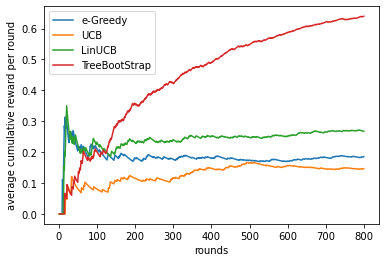

In [14]:
# your code here
mabs = [
    EpsGreedy(10, 0.05),
    UCB(10, 2.0),
    LinUCB(10, 10, 1.0),
    TreeBootstrap(10, 10)
]
names = [
    'e-Greedy',
    'UCB',
    'LinUCB',
    'TreeBootStrap'
]

x = list(range(1, 801))
for i in range(len(mabs)):
    results = offlineEvaluate(mabs[i], arms, rewards, contexts, 800)
    y = []
    for T in x:
        y.append(np.mean(results[:T]))
    plt.plot(x, y, label = names[i]) 

plt.xlabel('rounds') 
plt.ylabel('average cumulative reward per round') 
plt.legend() 
plt.show() 

### 5.B.

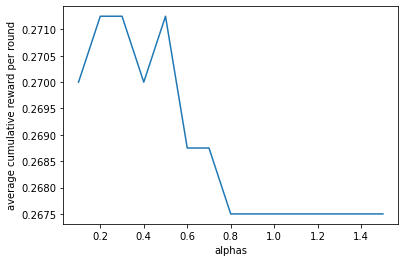

best alpha is: 0.5  with value: 0.27125


In [31]:
# your code here
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
results = []
for alpha in alphas:
    results.append(np.mean(offlineEvaluate(LinUCB(10, 10, alpha), arms, rewards, contexts, 800)))
plt.plot(alphas, results) 
    
plt.xlabel('alphas') 
plt.ylabel('average cumulative reward per round') 
plt.show() 

_max = max([(results[i], alphas[i]) for i in range(len(results))])
print("best alpha is:", _max[1], " with value:", _max[0])

## 6. Implement KernelUCB contextual MAB

In [42]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        # your code here
        if n_dims <= 0:
            raise ValueError("'n_dims' must be positive")
        if gamma <= 0:
            raise ValueError("'gamma' must be positive")
        if eta <= 0:
            raise ValueError("'eta' must be positive")
        self.n_dims = n_dims
        self.gamma = gamma
        self.eta = eta
        self.kernal = kern
        
        self.rewards = []
        self.x_t = [[] for i in range(self.n_arms)]
        self.y_t1 = []
        self.K_inv1 = None
        
    def play(self, context):
        super().play(context)
        # your code here
        u = np.array([0] * self.n_arms)
        if len(rewards) == 0:
            u[0] = 1
            u = u.T
        else:
            for a in range(self.n_arms):
                b = np.array([self.kernal(x, x) for x in self.x_t[a]]).T
                o_a = np.sqrt(self.kernal(context[a], context[a]) - b.T @ self.K_inv1 @ b)
                u[a] = b.T @ self.K_inv1 @ self.y_t1 + self.eta / np.sqrt(self.gamma) * o_a
        _max = max(u)
        _maxi = [i for i in range(self.n_arms) if abs(u[i]-_max) < 0.00001]
        arm = np.random.choice(_maxi)
        return arm
            
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        self.x_t[arm].append(context[arm])
        self.rewards.append(reward)
        self.y_t1 = np.array(self.rewards).T
        if len(self.rewards) == 1:
            self.K_inv1 = 1 / (self.kernal(context[arm], context[arm]) + self.gamma)
        else:
            b = np.array([self.kernal(x, x) for x in self.x_t[arm]]).T
            K22 = 1 / (self.kernal(context[arm], context[arm]) + self.gamma - b.T @ self.K_inv1 @ b)
            K11 = self.K_inv1 + K22 @ self.K_inv1 @ b @ b.T @ self.K_inv1
            K12 = -K22 @ b.T @ self.K_inv1
            self.K_inv1 = np.array([K11, K12, K21, K22])

In [43]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [39]:
# your plotting code here